# Earthquake Prediction

#### Table of Contents
0. Setup
1. Data Analysis
2. Data Preparation
3. Model Training
4. Model Evaluation

In [150]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## 0. Setup

In [151]:
filepath = './data/earthquakes.csv'

## 1. Data Analysis

In [152]:
df = pd.read_csv(filepath)
df = df.set_index('time')
df.index = pd.to_datetime(df.index)
df.head()

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
time,,,,,,,,,,,,,,,,,,,,,
2022-10-06 13:10:10.910000+00:00,33.972833,-116.675000,14.33,0.69,ml,15.0,79.0,0.06927,0.20,ci,...,2022-10-06T13:13:49.222Z,"12km SW of Morongo Valley, CA",earthquake,0.47,1.01,0.196,17.0,automatic,ci,ci
2022-10-06 13:10:10.910000+00:00,33.972833,-116.675000,14.33,0.69,ml,15.0,79.0,0.06927,0.20,ci,...,2022-10-06T13:13:49.222Z,"12km SW of Morongo Valley, CA",earthquake,0.47,1.01,0.196,17.0,automatic,ci,ci
2022-10-06 13:05:24.316000+00:00,59.726700,-152.436100,70.00,1.40,ml,NaN,NaN,NaN,0.30,ak,...,2022-10-06T13:06:46.715Z,"34 km W of Anchor Point, Alaska",earthquake,NaN,2.30,NaN,NaN,automatic,ak,ak
2022-10-06 13:05:24.316000+00:00,59.726700,-152.436100,70.00,1.40,ml,NaN,NaN,NaN,0.30,ak,...,2022-10-06T13:06:46.715Z,"34 km W of Anchor Point, Alaska",earthquake,NaN,2.30,NaN,NaN,automatic,ak,ak
2022-10-06 13:04:54+00:00,38.834999,-122.784332,1.89,1.02,md,17.0,66.0,0.00580,0.02,nc,...,2022-10-06T13:06:28.843Z,"6km WNW of Cobb, CA",earthquake,0.23,0.39,0.360,3.0,automatic,nc,nc


In [153]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,35245.000000,35245.000000,35245.000000,35244.000000,28039.000000,29242.000000,24219.000000,35245.000000,24990.000000,35245.000000,26445.000000,27361.000000
mean,37.167296,-108.587333,21.477970,1.663011,23.384821,116.449267,0.816615,0.275335,1.929262,4.240555,0.252210,17.163664
std,19.093452,67.751199,54.360028,1.311471,21.687507,60.421071,2.755243,0.272876,3.300828,389.379273,0.461743,34.172450
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,11.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.420500,-149.703200,3.600000,0.800000,10.000000,71.000000,0.025000,0.100000,0.280000,0.470000,0.103000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,17.000000,102.000000,0.059570,0.160000,0.480000,0.800000,0.160000,9.000000
75%,47.511900,-113.778167,14.560000,2.110000,29.000000,150.000000,0.165750,0.400000,1.090000,1.780000,0.236000,18.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,43.236000,2.460000,26.400000,73091.100000,5.520000,760.000000


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35245 entries, 2022-10-06 13:10:10.910000+00:00 to 2020-07-12 10:31:53.318000+00:00
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         35245 non-null  float64
 1   longitude        35245 non-null  float64
 2   depth            35245 non-null  float64
 3   mag              35244 non-null  float64
 4   magType          35244 non-null  object 
 5   nst              28039 non-null  float64
 6   gap              29242 non-null  float64
 7   dmin             24219 non-null  float64
 8   rms              35245 non-null  float64
 9   net              35245 non-null  object 
 10  id               35245 non-null  object 
 11  updated          35245 non-null  object 
 12  place            34456 non-null  object 
 13  type             35245 non-null  object 
 14  horizontalError  24990 non-null  float64
 15  depthError       35245 non-null  float64
 1

In [155]:
df.isnull().sum()

latitude               0
longitude              0
depth                  0
mag                    1
magType                1
nst                 7206
gap                 6003
dmin               11026
rms                    0
net                    0
id                     0
updated                0
place                789
type                   0
horizontalError    10255
depthError             0
magError            8800
magNst              7884
status                 0
locationSource         0
magSource              0
dtype: int64

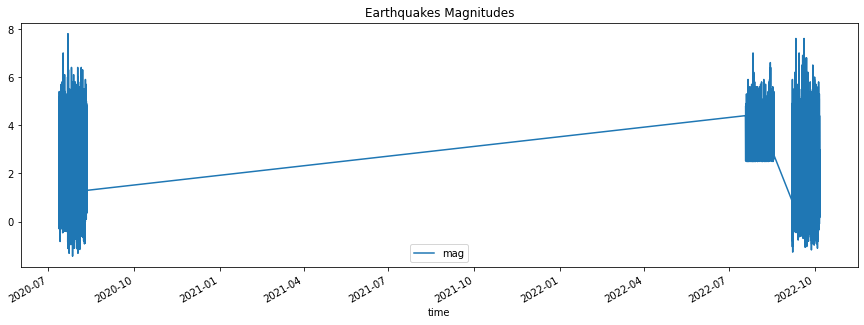

In [156]:
df.plot(figsize=(15, 5), title='Earthquakes Magnitudes', y='mag')
plt.show()

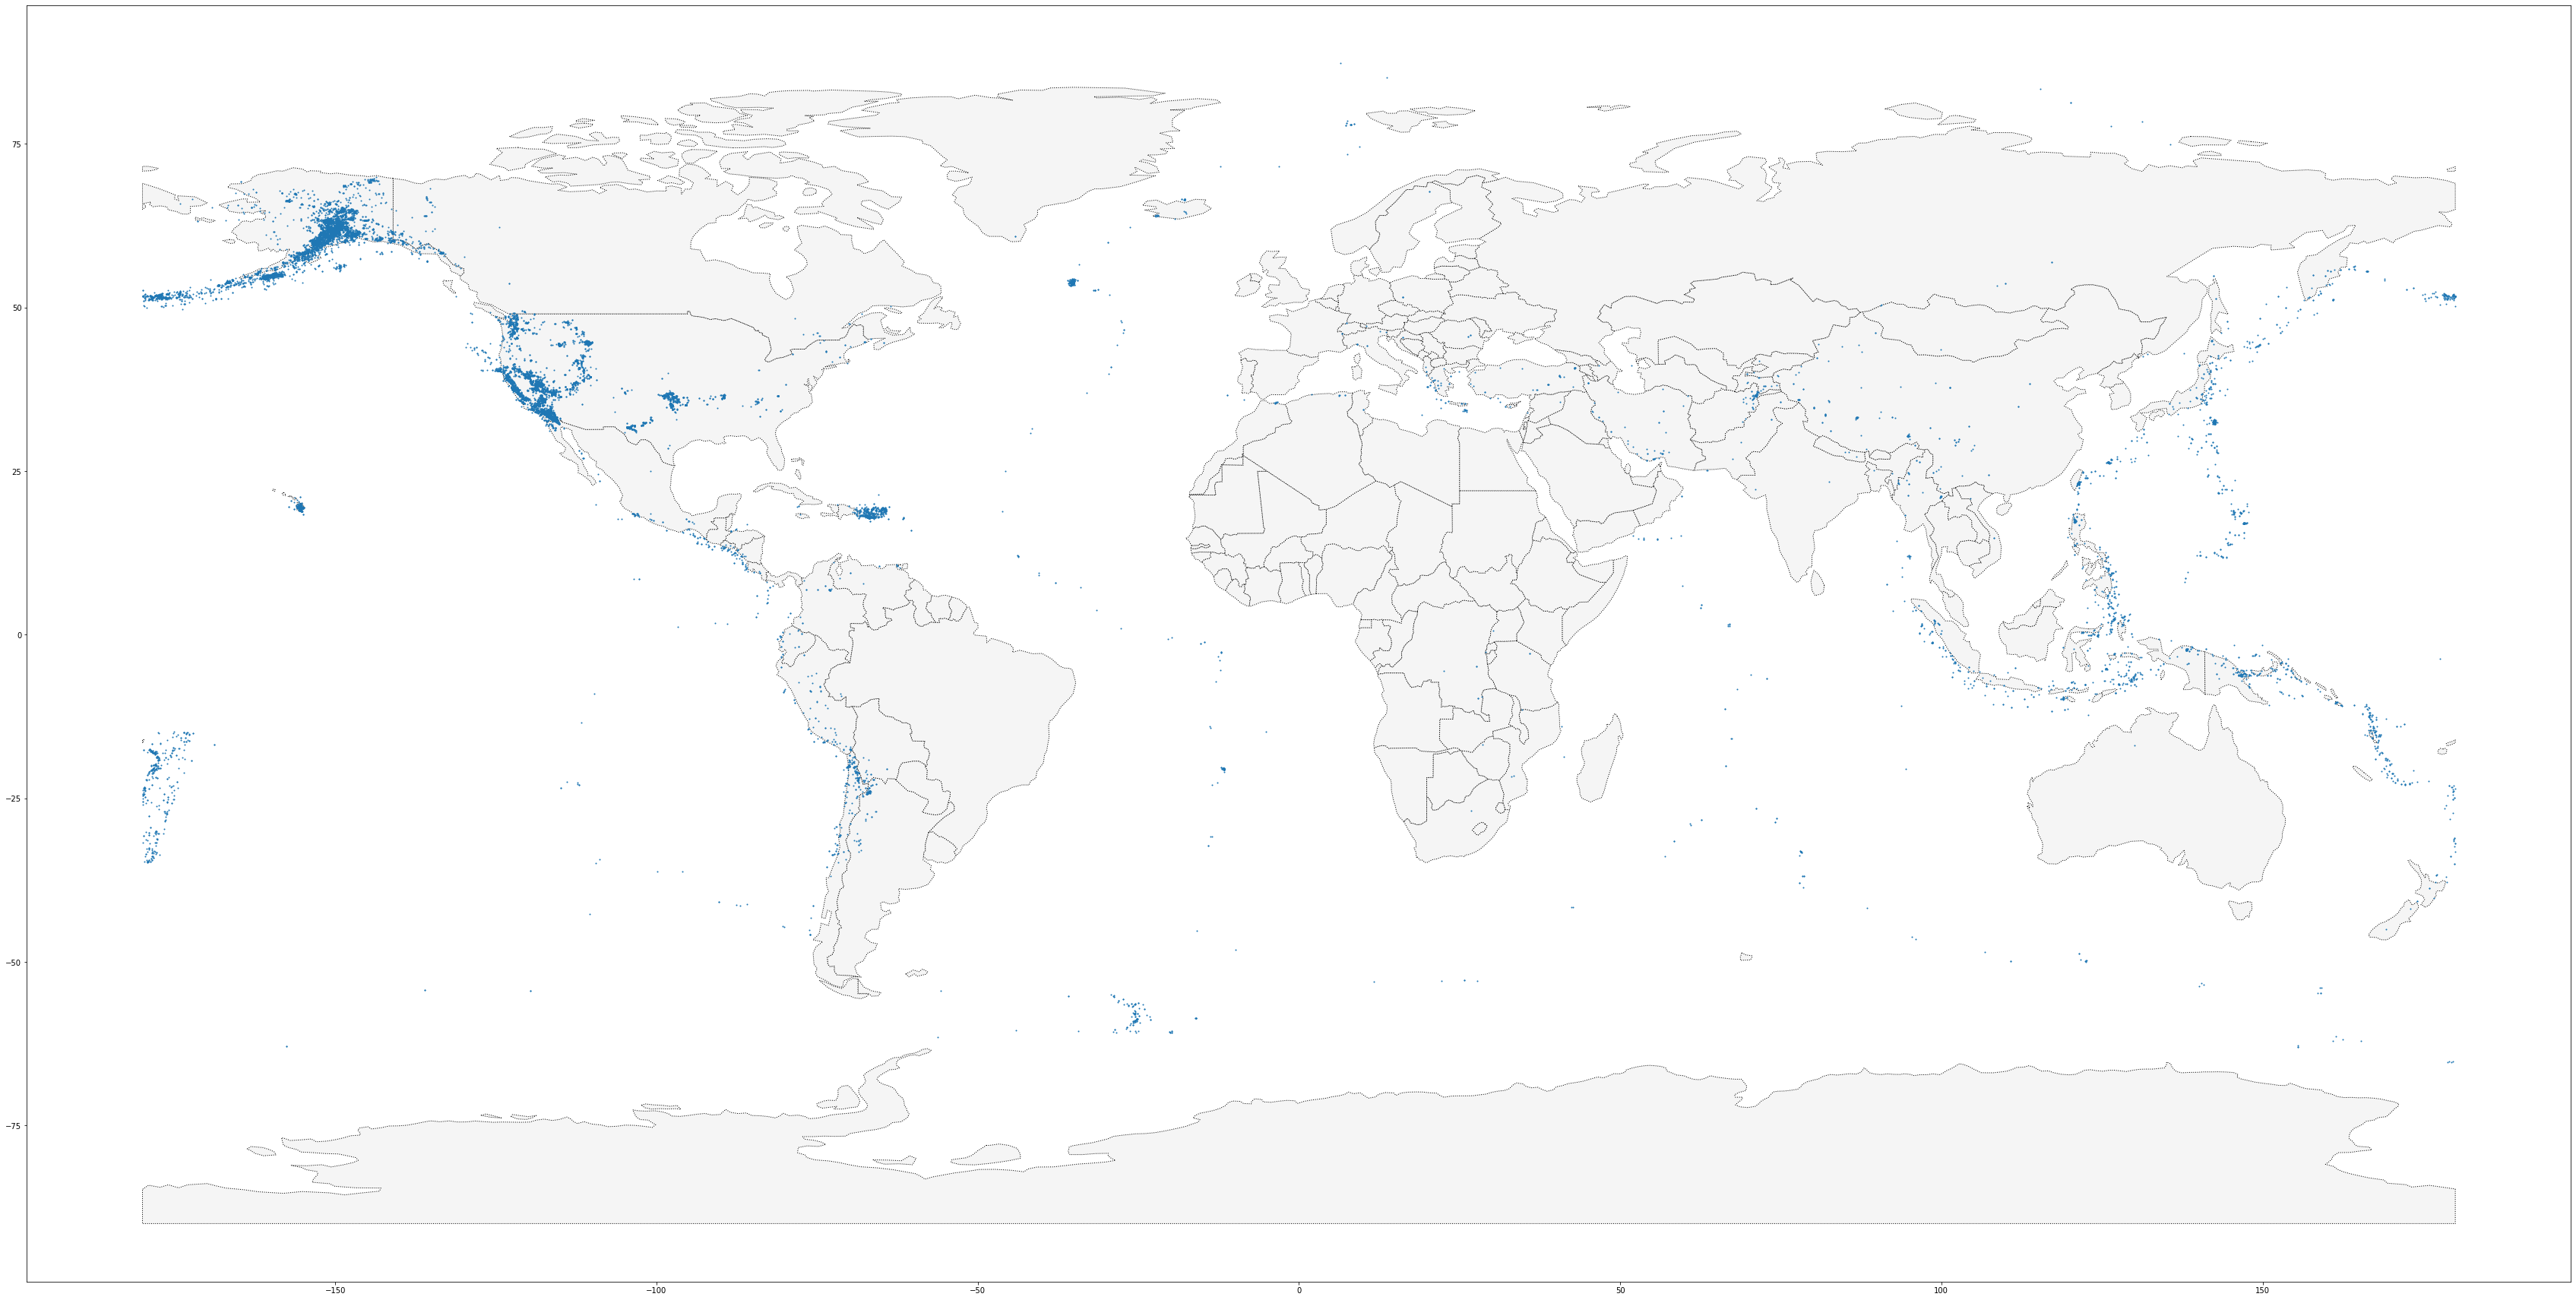

In [157]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [158]:
print(f'Min magnitude: {df.mag.min()}')
print(f'Max magnitude: {df.mag.max()}')

Min magnitude: -1.43
Max magnitude: 7.8


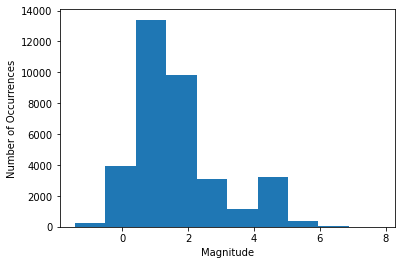

In [159]:
plt.hist(df.mag)
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

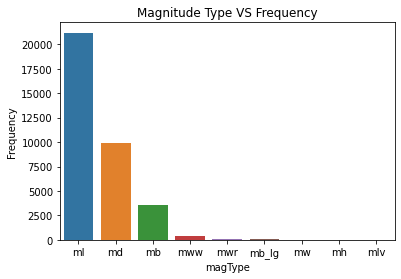

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [160]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [161]:
df.loc[df.mag >= 8, 'Class'] = 'Disastrous'
df.loc[(df.mag >= 7) & (df.mag < 7.9), 'Class'] = 'Major'
df.loc[(df.mag >= 6) & (df.mag < 6.9), 'Class'] = 'Strong'
df.loc[(df.mag >= 5.5) & (df.mag < 5.9), 'Class'] = 'Moderate'

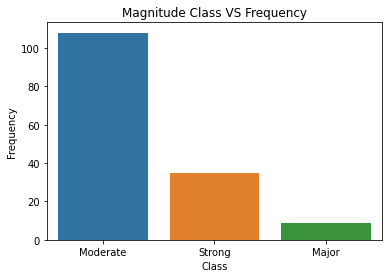

In [162]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

## 2. Data Preparation

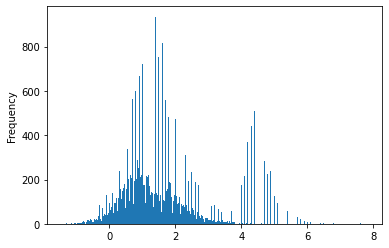

In [163]:
df.mag.plot(kind='hist', bins=500)
plt.show()

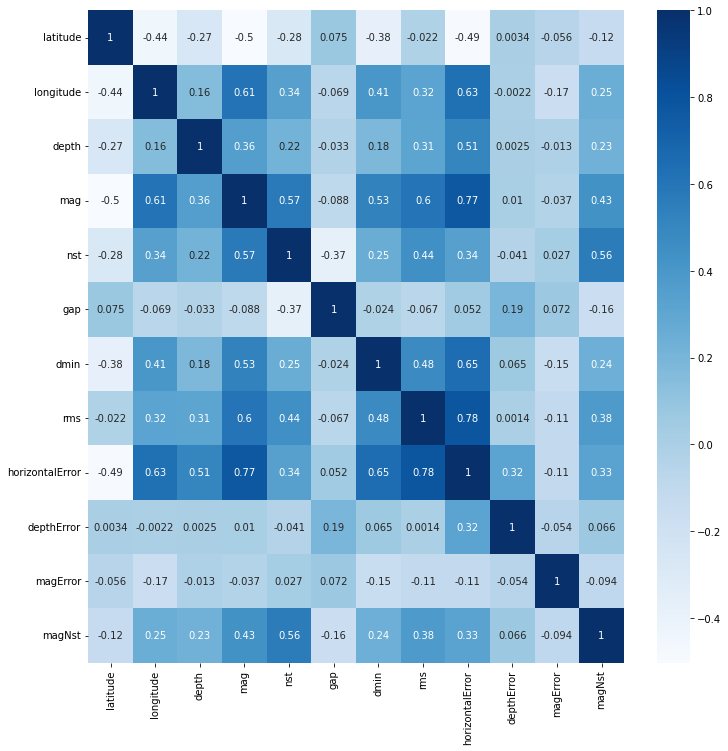

In [164]:
corr_matrix = df.corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

In [165]:
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)

In [166]:
for column in df.columns:
    if df[column].isna().mean() > 0.3:
        df = df.drop(column, axis=1) 

df = df.dropna(axis=0)

In [167]:
scaler = MinMaxScaler()

columns = ['nst', 'gap']
df[columns] = scaler.fit_transform(df[columns])

In [168]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index."""
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df.copy())

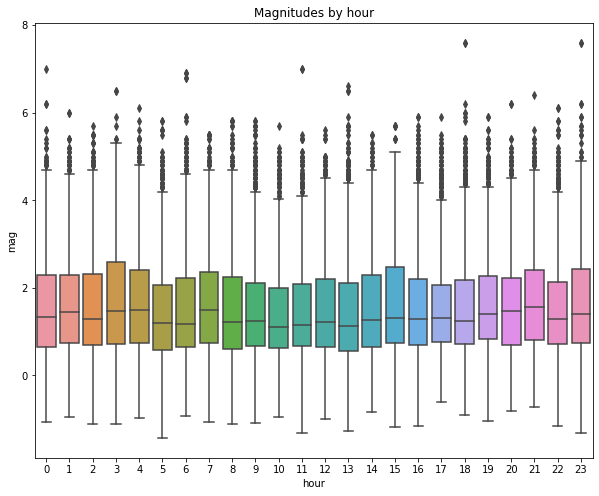

In [169]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='mag')
ax.set_title('Magnitudes by hour')
plt.show()

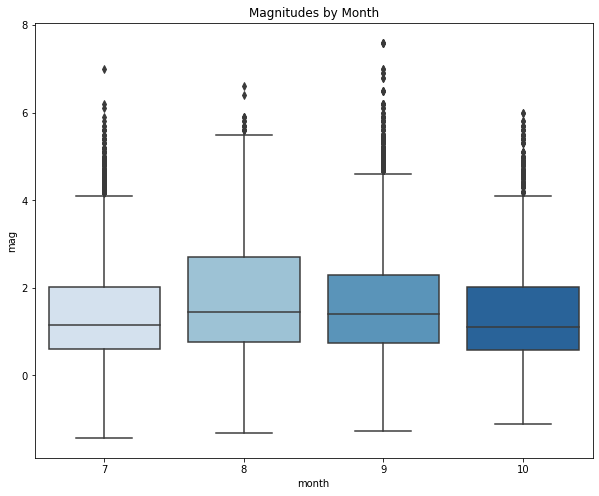

In [170]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mag', palette='Blues')
ax.set_title('Magnitudes by Month')
plt.show()

In [171]:
def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    target_map = df.mag.to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

## 3. Model Training

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22267 entries, 2022-10-06 13:10:10.910000+00:00 to 2020-07-12 10:38:04.580000+00:00
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   latitude         22267 non-null  float64 
 1   longitude        22267 non-null  float64 
 2   depth            22267 non-null  float64 
 3   mag              22267 non-null  float64 
 4   magType          22267 non-null  object  
 5   nst              22267 non-null  float64 
 6   gap              22267 non-null  float64 
 7   rms              22267 non-null  float64 
 8   net              22267 non-null  object  
 9   id               22267 non-null  object  
 10  updated          22267 non-null  object  
 11  place            22267 non-null  object  
 12  type             22267 non-null  object  
 13  horizontalError  22267 non-null  float64 
 14  depthError       22267 non-null  float64 
 15  magError         22267 non

In [173]:
# 'latitude', 'longitude', 'nst', 'gap', 'quarter', 'lag1','lag2','lag3',
features = ['dayofyear', 'hour', 'dayofweek', 'month', 'year', 'latitude', 'longitude']
# 'place', 'net', 'status'
cat_features = ['place']
target = 'mag'

In [174]:
date = '2022-09-23 00:00:00.000000+00:00'

df_train = df.loc[df.index < date]
df_train = df_train[features + cat_features + [target]]

df_test = df.loc[df.index >= date]
df_test = df_test[features + cat_features + [target]]

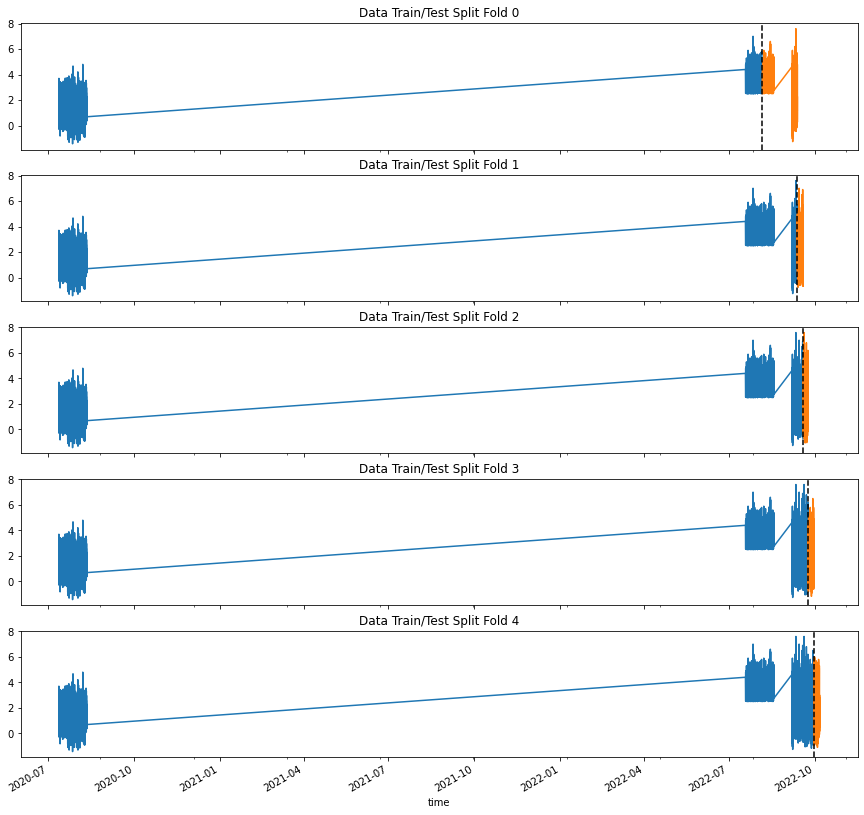

In [175]:
tss = model_selection.TimeSeriesSplit(n_splits=5, test_size=24 * 120, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.mag.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test.mag.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [176]:
# fold = 0
# preds = []
# scores = []
# for train_idx, val_idx in tss.split(df):
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]

#     train = create_features(train)
#     test = create_features(test)

#     FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
#                 'lag1','lag2','lag3']
#     TARGET = 'PJME_MW'

#     X_train = train[FEATURES]
#     y_train = train[TARGET]

#     X_test = test[FEATURES]
#     y_test = test[TARGET]

#     reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                            n_estimators=1000,
#                            early_stopping_rounds=50,
#                            objective='reg:linear',
#                            max_depth=3,
#                            learning_rate=0.01)
#     reg.fit(X_train, y_train,
#             eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=100)

#     y_pred = reg.predict(X_test)
#     preds.append(y_pred)
#     score = np.sqrt(mean_squared_error(y_test, y_pred))
#     scores.append(score)

In [177]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [178]:
grid = {
    'depth': [3, 5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.01],
    'iterations': [1000],
}

model = cb.CatBoostRegressor(
    early_stopping_rounds=50,
    cat_features=cat_features, 
)

grid_search_result = model.grid_search(
    grid, 
    x_train, 
    y_train,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0601727	test: 2.1248975	best: 2.1248975 (0)	total: 10.7ms	remaining: 10.7s
1:	learn: 1.9741030	test: 2.0345866	best: 2.0345866 (1)	total: 17.7ms	remaining: 8.81s
2:	learn: 1.8957251	test: 1.9519247	best: 1.9519247 (2)	total: 22.4ms	remaining: 7.44s
3:	learn: 1.8194804	test: 1.8721270	best: 1.8721270 (3)	total: 26.7ms	remaining: 6.65s
4:	learn: 1.7450066	test: 1.7939865	best: 1.7939865 (4)	total: 31.4ms	remaining: 6.25s
5:	learn: 1.6765355	test: 1.7230694	best: 1.7230694 (5)	total: 33.6ms	remaining: 5.57s
6:	learn: 1.6112620	test: 1.6543510	best: 1.6543510 (6)	total: 35.7ms	remaining: 5.07s
7:	learn: 1.5497416	test: 1.5894523	best: 1.5894523 (7)	total: 37.5ms	remaining: 4.64s
8:	learn: 1.4913371	test: 1.5286571	best: 1.5286571 (8)	total: 39.6ms	remaining: 4.36s
9:	learn: 1.4366466	test: 1.4709030	best: 1.4709030 (9)	total: 42.8ms	remaining: 4.23s
10:	learn: 1.3839910	test: 1.4158536	best: 1.4158536 (10)	total: 45.8ms	remaining: 4.12s
11:	learn: 1.3371251	test: 1.3666257	best

In [179]:
grid_search_result['params']

{'depth': 7, 'iterations': 1000, 'learning_rate': 0.1}

In [180]:
predictions = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, predictions)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, predictions))}')

Accuracy of Model: 0.8978154377974639
Mean Absolute Error: 0.32460582450494413
Root Mean Squared Error: 0.4390644087495351


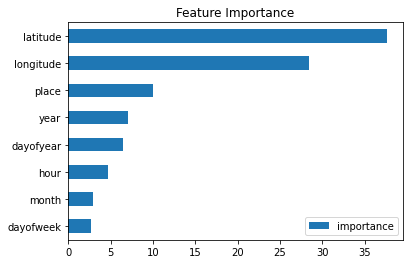

In [181]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Accuracy of Model: 0.8318242117113738
Mean Absolute Error: 0.4249833208591508
Root Mean Squared Error: 0.5859599123041743


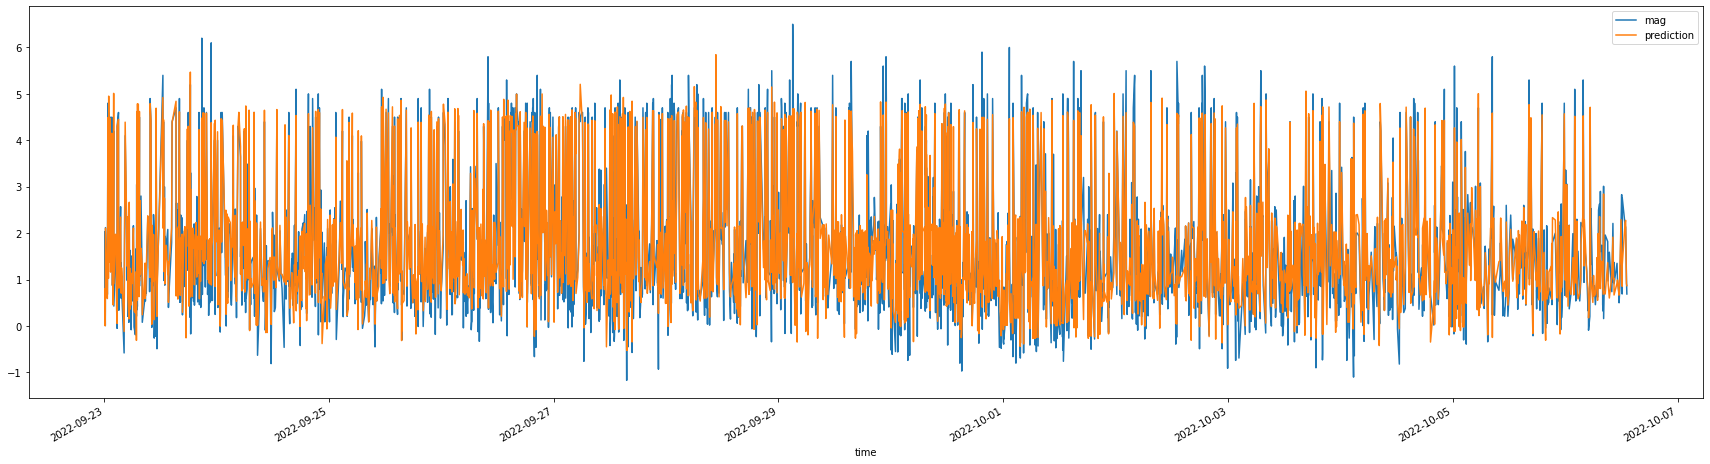

In [182]:
predictions = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], predictions)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(df_test[target], predictions))}')

df_plot = pd.DataFrame({'mag': df_test[target], 'prediction': predictions}, index=df_test.index)
df_plot = df_plot[::-1]
df_plot.plot(figsize=(30, 8))
plt.show()

In [184]:
model.save_model('../app/server/app/ml/model')